In [ ]:
# ! pip install seaborn
# ! pip install matplotlib

In [1]:
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
print(tf.__version__)

2.2.0


In [2]:
# Load TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path="face_landmark.tflite")
interpreter.allocate_tensors()

In [3]:
# Get tensor details.
details = interpreter.get_tensor_details()
for detail in details:
    print(detail['index'], detail['name'], detail['shape'])

0 input_1 [  1 192 192   3]
1 conv2d/Kernel [16  3  3  3]
2 conv2d/Bias [16]
3 conv2d [ 1 96 96 16]
4 p_re_lu/Alpha [ 1  1 16]
5 p_re_lu [ 1 96 96 16]
6 depthwise_conv2d/Kernel [ 1  3  3 16]
7 depthwise_conv2d/Bias [16]
8 depthwise_conv2d [ 1 96 96 16]
9 conv2d_1/Kernel [16  1  1 16]
10 conv2d_1/Bias [16]
11 conv2d_1 [ 1 96 96 16]
12 add [ 1 96 96 16]
13 p_re_lu_1/Alpha [ 1  1 16]
14 p_re_lu_1 [ 1 96 96 16]
15 depthwise_conv2d_1/Kernel [ 1  3  3 16]
16 depthwise_conv2d_1/Bias [16]
17 depthwise_conv2d_1 [ 1 96 96 16]
18 conv2d_2/Kernel [16  1  1 16]
19 conv2d_2/Bias [16]
20 conv2d_2 [ 1 96 96 16]
21 add_1 [ 1 96 96 16]
22 p_re_lu_2/Alpha [ 1  1 16]
23 p_re_lu_2 [ 1 96 96 16]
24 depthwise_conv2d_2/Kernel [ 1  3  3 16]
25 depthwise_conv2d_2/Bias [16]
26 depthwise_conv2d_2 [ 1 48 48 16]
27 max_pooling2d [ 1 48 48 16]
28 conv2d_3/Kernel [32  1  1 16]
29 conv2d_3/Bias [32]
30 conv2d_3 [ 1 48 48 32]
31 channel_padding/Paddings [4 2]
32 channel_padding [ 1 48 48 32]
33 add_2 [ 1 48 48 32]
34 p

In [4]:
def create_model():
    
    def get_small(prev, filt):
        prelutemp = tf.keras.layers.PReLU(shared_axes = [1, 2])(prev)
        deptconvtemp = tf.keras.layers.DepthwiseConv2D(3, padding='same')(prelutemp)
        convtemp = tf.keras.layers.Conv2D(filt, 1, strides=(1, 1), padding='same')(deptconvtemp)
        addtemp = tf.keras.layers.add([prelutemp, convtemp])
        return addtemp
    
    def get_big(prev, filt, pad):
        prelutemp = tf.keras.layers.PReLU(shared_axes = [1, 2])(prev)
        deptconvtemp = tf.keras.layers.DepthwiseConv2D(3, strides=(2, 2), padding='same')(prelutemp)
        maxpooltemp = tf.keras.layers.MaxPool2D()(prelutemp)
        convtemp = tf.keras.layers.Conv2D(filt, 1, strides=(1, 1), padding='same')(deptconvtemp)
        padtemp = tf.keras.layers.ZeroPadding2D(padding=(0, pad), data_format="channels_first")(maxpooltemp)
        addtemp = tf.keras.layers.add([convtemp, padtemp])
        return addtemp
        
    
    input1 = tf.keras.Input(shape=(192,192,3,))
    conv1 = tf.keras.layers.Conv2D(16, 3, strides=(2, 2), padding='same', activation=None)(input1)
    
    x = get_small(conv1, 16)
    x = get_small(x, 16)
    
    x = get_big(x, 32, 8)
    
    x = get_small(x, 32)
    x = get_small(x, 32)
    
    x = get_big(x, 64, 16)
    
    x = get_small(x, 64)
    x = get_small(x, 64)
    
    x = get_big(x, 128, 32)
    
    x = get_small(x, 128)
    x = get_small(x, 128)

    x = get_big(x, 128, 0)
    
    x = get_small(x, 128)
    x = get_small(x, 128)
    
    add1 = get_big(x, 128, 0)
    add2 = get_big(x, 128, 0)
    
    add1 = get_small(add1, 128)
    add1 = get_small(add1, 128)
    
    add2 = tf.keras.layers.PReLU(shared_axes = [1, 2])(add2)
    add2 = tf.keras.layers.Conv2D(32, 1, strides=(1, 1), padding='same')(add2)
    
    add2 = get_small(add2, 32)
    
    add2 = tf.keras.layers.PReLU(shared_axes = [1, 2])(add2)
    output1 = tf.keras.layers.Conv2D(1, 3, strides=(3, 3), padding='same')(add2)
    
    add1 = tf.keras.layers.PReLU(shared_axes = [1, 2])(add1)
    add1 = tf.keras.layers.Conv2D(32, 1, strides=(1, 1), padding='same')(add1)
    
    add1 = get_small(add1, 32)
    
    add1 = tf.keras.layers.PReLU(shared_axes = [1, 2])(add1)
    output2 = tf.keras.layers.Conv2D(1404, 3, strides=(3, 3), padding='same')(add1)
    
    model = tf.keras.models.Model(inputs = input1, outputs = [output1,output2])
    
    return model


model = create_model()
# model.save('model_1.h5')

In [5]:
# # Convert the model.
def convert_model(model):    
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    tflite_model = converter.convert()

    # Save the TF Lite model.
    with tf.io.gfile.GFile('model.tflite', 'wb') as f:
        f.write(tflite_model)
convert_model(model)

In [7]:
# # Load TFLite model and allocate tensors.
# interpreter1 = tf.lite.Interpreter(model_path="model.tflite")
# interpreter1.allocate_tensors()
# # Get tensor details.
# details = interpreter1.get_tensor_details()
# for detail in details:
#     print(detail['index'], detail['name'], detail['shape'])

In [8]:
def get_variable(interpreter, index, transposed=False):
    var = interpreter.get_tensor(index)
    if transposed:
        var = np.transpose(var, axes = (1,2,3,0))    
    return var

In [9]:
w1 = get_variable(interpreter, 1, True)
print(w1.shape)
b1 = get_variable(interpreter, 2)
print(b1.shape)

# w2 = get_variable(interpreter1, 4, True)
# print(w2.shape)
    

(3, 3, 3, 16)
(16,)


In [10]:
w1_tensor = tf.constant(w1)
b1_tensor = tf.constant(b1)
weight_tensor =[w1_tensor, b1_tensor]
weight_tensor

[<tf.Tensor: shape=(3, 3, 3, 16), dtype=float32, numpy=
 array([[[[-4.17059302e-01, -5.06236143e-02,  5.77255249e-01,
           -1.97633296e-01,  3.28671366e-01,  8.22490692e-01,
            1.20241649e-01, -4.16660994e-01,  1.09554894e-01,
           -2.42108181e-02, -1.17261338e+00,  1.53983951e-01,
           -1.16128087e-01, -9.79946673e-01, -8.88055116e-02,
           -1.95930317e-01],
          [ 3.72474268e-02, -4.05667573e-01,  3.61265928e-01,
            2.00785086e-01,  4.09817606e-01,  3.86782765e-01,
            5.82456410e-01, -4.87642348e-01,  1.06390782e-01,
           -1.82200477e-01, -7.99726129e-01,  7.01038837e-01,
            4.99215662e-01,  3.16073775e-01,  3.06642562e-01,
           -3.21699888e-01],
          [ 6.82788715e-02,  4.79811989e-02,  2.05687329e-01,
            3.07599962e-01, -5.71287349e-02,  9.62954879e-01,
            8.52408558e-02, -2.71992236e-01,  1.04893580e-01,
           -1.60810739e-01, -7.45624125e-01,  8.46352100e-01,
           -7.0116

In [11]:
model_layer = model.get_layer(index = 1)
model_layer.set_weights(weight_tensor)
model_layer.weights

[<tf.Variable 'conv2d/kernel:0' shape=(3, 3, 3, 16) dtype=float32, numpy=
 array([[[[-4.17059302e-01, -5.06236143e-02,  5.77255249e-01,
           -1.97633296e-01,  3.28671366e-01,  8.22490692e-01,
            1.20241649e-01, -4.16660994e-01,  1.09554894e-01,
           -2.42108181e-02, -1.17261338e+00,  1.53983951e-01,
           -1.16128087e-01, -9.79946673e-01, -8.88055116e-02,
           -1.95930317e-01],
          [ 3.72474268e-02, -4.05667573e-01,  3.61265928e-01,
            2.00785086e-01,  4.09817606e-01,  3.86782765e-01,
            5.82456410e-01, -4.87642348e-01,  1.06390782e-01,
           -1.82200477e-01, -7.99726129e-01,  7.01038837e-01,
            4.99215662e-01,  3.16073775e-01,  3.06642562e-01,
           -3.21699888e-01],
          [ 6.82788715e-02,  4.79811989e-02,  2.05687329e-01,
            3.07599962e-01, -5.71287349e-02,  9.62954879e-01,
            8.52408558e-02, -2.71992236e-01,  1.04893580e-01,
           -1.60810739e-01, -7.45624125e-01,  8.46352100e-01,


In [12]:
convert_model(model)

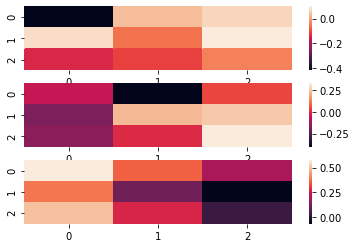

In [13]:
f, axes = plt.subplots(3)
c1 = w1[0][:,:,0]
c2 = w1[0][:,:,1]
c3 = w1[0][:,:,2]

sns.heatmap(c1, ax = axes[0])
sns.heatmap(c2, ax = axes[1])
sns.heatmap(c3, ax = axes[2])